Fit univariate binomial LMEs to quantify 1) the site effect and 2) the predictive effect size in each feature.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import scipy.stats

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from medl.metrics import classification_metrics


In [2]:
lsContinuousFeatures = ['AGE', 'PTEDUCAT', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
       'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
       'TRABSCOR_bl', 'FAQ_bl', 'mPACCdigit_bl',
       'mPACCtrailsB_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'ABETA_bl', 'TAU_bl', 'PTAU_bl',
       'FDG_bl']

lsCategoricalFeatures = ['PTGENDER', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4']

In [3]:
# Read in the original dataset which contains the site information
dfData = pd.read_csv('../data/adni/baseline_features_24mo_imputeddx.csv', index_col=0)
dfTarget = pd.read_csv('../data/adni/target_24mo_imputeddx.csv', index_col=0)

In [4]:
largest5Sites = dfData['SITE'].value_counts().sort_values().index[-1:-6:-1]

for strFeature in lsContinuousFeatures:
    dfVariables = dfData[[strFeature, 'SITE']].copy()
    dfVariables['CONVERSION'] = dfTarget['0'].apply(lambda x: 'Converter' if x else 'Non-converter')
    dfVariables.dropna(inplace=True)

    fig, ax = plt.subplots(6, 1, figsize=(10, 12), sharex=True)

    for iSite in range(5):
        dfVariablesSite = dfVariables.loc[dfVariables['SITE'] == largest5Sites[iSite]]

        sns.histplot(data=dfVariablesSite, x=strFeature, hue='CONVERSION', hue_order=['Converter', 'Non-converter'], ax=ax[iSite],
                     legend=(iSite == 0))
        ax[iSite].set_title('Site ' + str(largest5Sites[iSite]))

    sns.histplot(data=dfVariables, x=strFeature, hue='CONVERSION', hue_order=['Converter', 'Non-converter'], ax=ax[5], legend=False)
    ax[5].set_title('All')

    fig.suptitle(strFeature)
    plt.show()

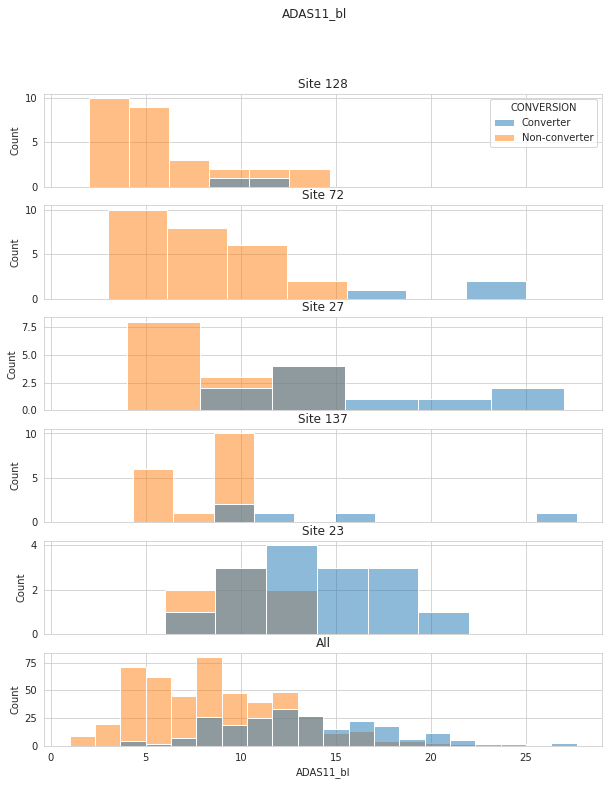

In [17]:
strFeature = 'ADAS11_bl'

dfVariables = dfData[[strFeature, 'SITE']].copy()
dfVariables['CONVERSION'] = dfTarget['0'].apply(lambda x: 'Converter' if x else 'Non-converter')
dfVariables.dropna(inplace=True)

fig, ax = plt.subplots(6, 1, figsize=(10, 12), sharex=True)

for iSite in range(5):
    dfVariablesSite = dfVariables.loc[dfVariables['SITE'] == largest5Sites[iSite]]

    sns.histplot(data=dfVariablesSite, x=strFeature, hue='CONVERSION', hue_order=['Converter', 'Non-converter'], ax=ax[iSite],
                    legend=(iSite == 0))
    ax[iSite].set_title('Site ' + str(largest5Sites[iSite]))

sns.histplot(data=dfVariables, x=strFeature, hue='CONVERSION', hue_order=['Converter', 'Non-converter'], ax=ax[5], legend=False)
ax[5].set_title('All')

fig.suptitle(strFeature)
plt.show()

In [18]:
strFeature = 'ADAS11_bl'

dfVariables = dfData[[strFeature, 'SITE']].copy()
dfVariables['CONVERSION'] = dfTarget
dfVariables.dropna(inplace=True)

dfVariables = dfVariables.loc[dfVariables['SITE'].apply(lambda x: x in largest5Sites)]

strFormula = f'CONVERSION ~ {strFeature}'
dictRandomEffects = {'site_slope': f'0 + C(SITE):{strFeature}'}

model = BinomialBayesMixedGLM.from_formula(strFormula, dictRandomEffects, dfVariables)             
result = model.fit_vb()

# Fixed effect-based predictions (before logit transformation)
arrPredLinear = result.predict(linear=True)
# Add in random effects
dfRE = result.random_effects()
nSamples = dfVariables.shape[0]
lsREMult = [np.inner(model.exog_vc[j].toarray().flatten(), dfRE['Mean'].values) for j in range(nSamples)]
arrRandomEffects = np.array(lsREMult)
arrPredMixedLinear = arrPredLinear+ arrRandomEffects

# Convert to logits using link function
arrMixedPredLogit = model.family.link.inverse(arrPredMixedLinear)
dfPredictionsME = pd.Series(arrMixedPredLogit, index=dfVariables.index)

dictMetricsME = classification_metrics(dfVariables['CONVERSION'], dfPredictionsME)[0]

glm = sm.GLM.from_formula(f'CONVERSION ~ {strFeature}', dfVariables, family=sm.families.Binomial())         
resultGLM = glm.fit()

dfPredictionsGLM = pd.Series(resultGLM.predict(), index=dfVariables.index)
dictMetricsGLM = classification_metrics(dfVariables['CONVERSION'], dfPredictionsGLM)[0]

dfMetrics = pd.DataFrame([dictMetricsGLM, dictMetricsME], index=['GLM', 'ME'])
dfMetrics

,AUROC,Accuracy,Youden's index,F1,PPV,NPV,Sensitivity,Specificity
GLM,0.904916,0.828125,0.620891,0.710526,0.658537,0.908046,0.771429,0.849462
ME,0.937174,0.867188,0.710292,0.773333,0.725000,0.931818,0.828571,0.881720


Find the decision boundaries/thresholds for each model. We'll do this by passing in a range of feature values and finding which value yields a prediction greater than the Youden point.

In [21]:
# subjects below the threshold are converters
bConverterLower = False

# Range of feature values to test
arrFeatureValues = np.linspace(0, 30, 100)
# arrFeatureValues = np.linspace(-20, 5, 100)

In [22]:
dfExog = pd.DataFrame({strFeature: arrFeatureValues})
dfLogits = resultGLM.predict(dfExog)
youdenGLM = classification_metrics(dfVariables['CONVERSION'], dfPredictionsGLM)[1]
if bConverterLower:
    threshGLM = arrFeatureValues[dfLogits < youdenGLM][0]
else:
    threshGLM = arrFeatureValues[dfLogits > youdenGLM][0]

print('GLM threshold:', threshGLM)

GLM threshold: 11.515151515151516


Finding the global threshold for the ME model.

In [23]:
arrExog = np.vstack([np.ones(arrFeatureValues.size), arrFeatureValues]).T
arrLogits = result.predict(arrExog)
youdenME = classification_metrics(dfVariables['CONVERSION'], dfPredictionsME)[1]

if bConverterLower:
    threshME = arrFeatureValues[arrLogits < youdenME][0]
else:
    threshME = arrFeatureValues[arrLogits > youdenME][0]

print('ME model global threshold:', threshME)

ME model global threshold: 12.121212121212121


Finding the site-specific thresholds for the ME model (accounting for site-specific slopes).

In [24]:
for site in largest5Sites:
    strSite = str(site)
    fSiteSlope = dfRE['Mean'].filter(like=strSite).values[0]

    arrPredLinear = result.predict(arrExog, linear=True)
    # Compute the prediction incorporating the site slope
    arrPredMELinear = arrPredLinear + arrExog[:, 1] * fSiteSlope

    # Logit transform
    arrPredLogit = model.family.link.inverse(arrPredMELinear)
    
    if bConverterLower:
        threshME = arrFeatureValues[arrPredLogit < youdenME][0]
    else:
        threshME = arrFeatureValues[arrPredLogit > youdenME][0]

    print('Site', strSite, 'threshold:', threshME)



Site 128 threshold: 13.93939393939394
Site 72 threshold: 15.454545454545455
Site 27 threshold: 11.515151515151516
Site 137 threshold: 11.515151515151516
Site 23 threshold: 9.393939393939394


In [25]:
# break down performance by site
lsMetricsSite = []

for site in largest5Sites.values:
    dictGLM = classification_metrics(dfVariables['CONVERSION'].loc[dfVariables['SITE'] == site],
                                     dfPredictionsGLM.loc[dfVariables['SITE'] == site], youdenGLM)[0]

    dictME = classification_metrics(dfVariables['CONVERSION'].loc[dfVariables['SITE'] == site],
                                     dfPredictionsME.loc[dfVariables['SITE'] == site], youdenME)[0]

    dfMetricsSite = pd.concat([pd.Series(dictGLM), pd.Series(dictME)], keys=['GLM', 'ME'])

    lsMetricsSite += [dfMetricsSite]

dfMetricsPerSite = pd.concat(lsMetricsSite, axis=1).T
dfMetricsPerSite.index = largest5Sites
    

In [26]:
dfMetricsPerSite

GLM                                                         \
        AUROC  Accuracy Youden's index        F1       PPV       NPV   
128  0.892857  0.866667       0.392857  0.333333  0.250000  0.961538   
72   1.000000  0.862069       0.846154  0.600000  0.428571  1.000000   
27   0.886667  0.760000       0.566667  0.750000  0.642857  0.909091   
137  0.882353  0.909091       0.600000  0.750000  1.000000  0.894737   
23   0.823810  0.727273       0.447619  0.785714  0.846154  0.555556   

                                   ME                                     \
    Sensitivity Specificity     AUROC  Accuracy Youden's index        F1   
128    0.500000    0.892857  0.892857  0.900000      -0.035714  0.000000   
72     1.000000    0.846154  1.000000  1.000000       1.000000  1.000000   
27     0.900000    0.666667  0.886667  0.760000       0.566667  0.750000   
137    0.600000    1.000000  0.882353  0.909091       0.600000  0.750000   
23     0.733333    0.714286  0.823810  0.727273       0.219048  0.823529   

                                                 
          PPV       NPV Sensitivity Specificity  
128  0.000000  0.931034    0.000000    0.964286  
72   1.000000  1.000000    1.000000    1.000000  
27   0.642857  0.909091    0.900000    0.666667  
137  1.000000  0.894737    0.600000    1.000000  
23   0.736842  0.666667    0.933333    0.285714

In [28]:
result.random_effects()

,Mean,SD
C(SITE)[23]:ADAS11_bl,0.117484,0.045337
C(SITE)[27]:ADAS11_bl,0.021283,0.042596
C(SITE)[72]:ADAS11_bl,-0.093844,0.047095
C(SITE)[128]:ADAS11_bl,-0.060156,0.060352
C(SITE)[137]:ADAS11_bl,0.016614,0.053800
